In [207]:
import pickle
import random
from statistics import mean
from statistics import stdev
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
import sqlite3
import prettytable
	
from sklearn.utils import resample
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_class_weight

In [2]:
with open('../datafiles/pickles/affr_bow_500','rb') as affr_bow_500:
    affr_bow_500 = pickle.load(affr_bow_500).toarray()
    print(affr_bow_500.shape,affr_bow_500[0])
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

with open('../datafiles/pickles/affr_bigram_bow_500','rb') as affr_bigram_bow_500:
    affr_bigram_bow_500 = pickle.load(affr_bigram_bow_500).toarray()
    print(affr_bigram_bow_500.shape,affr_bigram_bow_500[0])
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

with open('../datafiles/pickles/affr_ngram_tfidf_500','rb') as affr_ngram_tfidf_500:
    affr_ngram_tfidf_500 = pickle.load(affr_ngram_tfidf_500).toarray()
    print(affr_ngram_tfidf_500.shape,affr_ngram_tfidf_500[0])
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

with open('../datafiles/pickles/avg_w2v','rb') as avg_w2v:
    avg_w2v = np.array(pickle.load(avg_w2v))
    print(avg_w2v.shape,avg_w2v[0])
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

with open('../datafiles/pickles/tdifd_weighted_w2v','rb') as tdifd_weighted_w2v:
    tdifd_weighted_w2v = np.array(pickle.load(tdifd_weighted_w2v))
    print(tdifd_weighted_w2v.shape,tdifd_weighted_w2v[0])

(364171, 500) [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 

In [228]:
conn = sqlite3.connect('../datafiles/amazon_reviews.sqlite')
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score!=3""",conn)
def scr(s):
    if(s>3):
        return 1
    else:
        return 0
data['Score'] = data['Score'].apply(scr)
cus_data = data.drop_duplicates(subset={'UserId','ProfileName', 'Time', 'Text'},keep='first')
cus_data = cus_data[cus_data['HelpfulnessNumerator']<=cus_data['HelpfulnessDenominator']]
Scr = cus_data['Score'].copy()

In [243]:
df = pd.DataFrame(avg_w2v)
df['Y']  = Scr
df.dropna(inplace=True)
df.reset_index(drop=True)
dataa = df.iloc[10000:15000].copy()
df_mino = dataa[dataa['Y']==0].copy()
df_majo = dataa[dataa['Y']==1].copy()

In [244]:
df_minority_upsampled = resample(df_mino,replace=True,n_samples=df_majo.shape[0],random_state=123)
df_upsampled = pd.concat([df_majo, df_minority_upsampled])

In [246]:
df_upsampled['Y'].value_counts()

0.0    4249
1.0    4249
Name: Y, dtype: int64

In [135]:
class Knn:
    def __init__(self,X,Y,algorithm='auto'):
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.algorithm = algorithm

    def KNN_TS(self,time_splits=5):
        self.X_train_n_cv, self.X_test, self.Y_train_n_cv, self.Y_test = train_test_split(self.X,self.Y,test_size=0.3,random_state=0)
        tscv = TimeSeriesSplit()
        TimeSeriesSplit(max_train_size=None, n_splits=time_splits)
        scrs = list()
        auroc_score = dict()
        self.roc_auc_stats = list()
        for n in tqdm(range(1,100,3)):
            cv_fold_score = list()
            train_fold_score = list()
            auroc_fold_score = list()
            auroc_fold_score_proba = list()
            auroc_fold_train = list()
            for train_index, cv_index in tscv.split(self.X_train_n_cv):
                X_train,Y_train = self.X_train_n_cv[train_index],self.Y_train_n_cv[train_index]
                X_cv,Y_cv = self.X_train_n_cv[cv_index],self.Y_train_n_cv[cv_index]
                model = KNeighborsClassifier(n_neighbors = n, algorithm = self.algorithm)  
                model.fit(X_train,Y_train)
                y_cv_pred_proba = model.predict_proba(X_cv)[:,1]
                y_cv_pred = model.predict(X_cv)
                cv_fold_score.append(model.score(X_cv,Y_cv))
                train_fold_score.append(model.score(X_train,Y_train))
                auroc_fold_score_proba.append(roc_auc_score(Y_cv,y_cv_pred_proba))
                auroc_fold_score.append(roc_auc_score(Y_cv,y_cv_pred))
                auroc_fold_train.append(roc_auc_score(Y_train,model.predict_proba(X_train)[:,1]))
            scrs.append([n,mean(cv_fold_score),mean(train_fold_score),mean(auroc_fold_score),mean(auroc_fold_score_proba)])
            auroc_score[n] = mean(auroc_fold_score_proba)
            self.roc_auc_stats.append([n,mean(auroc_fold_train),stdev(auroc_fold_train),mean(auroc_fold_score_proba),stdev(auroc_fold_score_proba)])
        max_roc_score = max(auroc_score.values())
        scrs = pd.DataFrame(data = scrs,columns=['K','CV score','Train score','AUROC','AUROC with probability'])
        optimal_k = max(auroc_score, key=auroc_score.get)
        self.scrs = scrs
        self.max_roc_score = max_roc_score
        self.optimal_k = optimal_k
        self.op_model = KNeighborsClassifier(n_neighbors = optimal_k,algorithm = self.algorithm)
        self.op_model.fit(self.X_train_n_cv,self.Y_train_n_cv)
        return self.op_model

    def Plot_roc(self):
        y_probability = self.op_model.predict_proba(self.X_test)
        fpr, tpr, threshold = roc_curve(self.Y_test, y_probability[:,1])
        roc_auc = roc_auc_score(self.Y_test, y_probability[:,1])
        plt.title('Receiver Operating Characteristic Test data')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.title('ROC Curve of kNN')
        plt.show()

    def Plot_CV_roc_score(self):
        rocstats = np.array(self.roc_auc_stats)
        sns.set_style("darkgrid")
        sns.set_palette(sns.color_palette("Dark2", 2))
        sns.lineplot(y=rocstats[:,1],x=rocstats[:,0],label = "Train AUROC")
        sns.lineplot(y=rocstats[:,3],x=rocstats[:,0],label = "CV AUROC")  
        plt.fill_between(x=rocstats[:,0],y1=rocstats[:,3]+rocstats[:,4],y2=rocstats[:,3]-rocstats[:,4],color="#ffd1b3")
        plt.fill_between(x=rocstats[:,0],y1=rocstats[:,1]+rocstats[:,2],y2=rocstats[:,1]-rocstats[:,2],color="#B4EEB4")
        plt.title("ROC score of Train and CV data set with it's spanning standard deviation")
        plt.ylabel('ROC score')
        plt.xlabel('K as hyperparameter')       

    def Plot_CV_scrs(self):
        trn_err = self.scrs['Train score'].apply(lambda x: 1-x,1)
        cv_err = self.scrs['CV score'].apply(lambda x: 1-x,1)
        sns.lineplot(y='CV score',x='K',data=self.scrs)
        sns.lineplot(y='Train score',x='K',data=self.scrs)
        fig = plt.figure()
        sns.lineplot(y=cv_err,x='K',data=self.scrs)
        sns.lineplot(y=trn_err,x='K',data=self.scrs)

    def Confusion_mat(self):
        tbl = prettytable([' ','',''])
        test_mat = confusion_matrix(self.Y_test,self.model.predict(self.X_test))
        train_mat = confusion_matrix(self.Y_train_n_cv,self.model.predict(self.X_train_n_cv))
        plot_confusion_matrix(self.model, self.X_train_n_cv, self.Y_train_n_cv)
        plt.show()


    def KNN_KCV(self,fold=10):
        self.X = pd.DataFrame(self.X)
        self.Y = pd.DataFrame(self.Y)
        self.X_train_n_cv, self.X_test, self.Y_train_n_cv, self.Y_test = train_test_split(self.X,self.Y,test_size=0.3,random_state=0)
        indx = list(self.X_train_n_cv.index)
        random.shuffle(indx)
        split = [indx[i::fold] for i in range(fold)]
        scrs = list()
        auroc_score = dict()
        self.roc_auc_stats = list()
        for n in tqdm(range(1,100,2)):
            cv_fold_score = list()
            train_fold_score = list()
            auroc_fold_score = list()
            auroc_fold_score_proba = list()
            auroc_fold_train = list()
            for j in range(1,fold+1):
                X_train  = self.X_train_n_cv.loc[list(set(self.X_train_n_cv.index)-set(split[j-1]))] 
                Y_train  = self.Y_train_n_cv.loc[list(set(self.X_train_n_cv.index)-set(split[j-1]))]
                X_cv  = self.X_train_n_cv.loc[split[j-1]]
                Y_cv  = self.Y_train_n_cv.loc[split[j-1]]
                model = KNeighborsClassifier(n_neighbors = n, algorithm = self.algorithm)
                model.fit(X_train,Y_train)
                y_cv_pred_proba = model.predict_proba(X_cv)[:,1]
                y_cv_pred = model.predict(X_cv)
                cv_fold_score.append(model.score(X_cv,Y_cv))
                train_fold_score.append(model.score(X_train,Y_train))
                auroc_fold_score_proba.append(roc_auc_score(Y_cv,y_cv_pred_proba))
                auroc_fold_score.append(roc_auc_score(Y_cv,y_cv_pred))
                auroc_fold_train.append(roc_auc_score(Y_train,model.predict_proba(X_train)[:,1]))
            scrs.append([n,mean(cv_fold_score),mean(train_fold_score),mean(auroc_fold_score),mean(auroc_fold_score_proba)])
            auroc_score[n] = mean(auroc_fold_score_proba)
            self.roc_auc_stats.append([n,mean(auroc_fold_train),stdev(auroc_fold_train),mean(auroc_fold_score_proba),stdev(auroc_fold_score_proba)])
        max_roc_score = max(auroc_score.values())
        scrs = pd.DataFrame(data = scrs,columns=['K','CV score','Train score','AUROC','AUROC with probability'])
        optimal_k = max(auroc_score, key=auroc_score.get)
        self.max_roc_score = max_roc_score
        self.scrs = scrs
        self.optimal_k = optimal_k
        self.op_model = KNeighborsClassifier(n_neighbors = optimal_k,algorithm = self.algorithm)
        self.op_model.fit(self.X_train_n_cv,self.Y_train_n_cv)
        return self.op_model


In [137]:
# knn = Knn(tdifd_weighted_w2v,Scr[0:1000])
knn = Knn(avg_w2v[11000:12000],Scr[11000:12000])

In [111]:
op_model = knn.KNN_TS()

100%|██████████| 33/33 [00:28<00:00,  1.14it/s]


In [139]:
def Confusion_matt(self):
    # tbl = prettytable([' ','',''])
    # test_mat = confusion_matrix(self.Y_test,self.model.predict(self.X_test))
    # train_mat = confusion_matrix(self.Y_train_n_cv,self.model.predict(self.X_train_n_cv))
    plot_confusion_matrix(self.op_model, self.X_train_n_cv, self.Y_train_n_cv)
    plot_confusion_matrix(self.op_model, self.X_test, self.Y_test)
    plt.show()

Knn.matt = Confusion_matt

In [142]:
knn.optimal_k

99

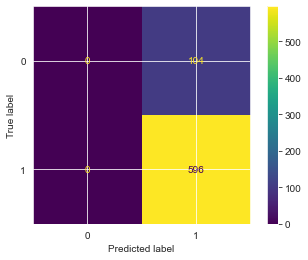

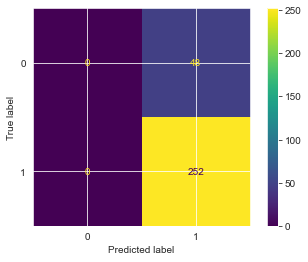

In [140]:
knn.matt()

Text(0.5, 0, 'K as hyperparameter')

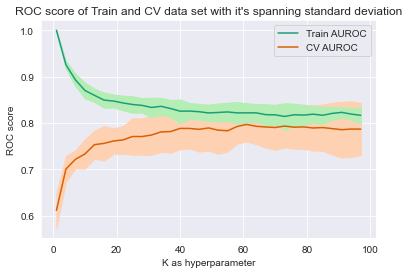

In [101]:
sns.set_style("darkgrid")
sns.set_palette(sns.color_palette("Dark2", 2))
sns.lineplot(y=rocstats[:,1],x=rocstats[:,0],label = "Train AUROC")
sns.lineplot(y=rocstats[:,3],x=rocstats[:,0],label = "CV AUROC")  
plt.fill_between(x=rocstats[:,0],y1=rocstats[:,3]+rocstats[:,4],y2=rocstats[:,3]-rocstats[:,4],color="#ffd1b3")
plt.fill_between(x=rocstats[:,0],y1=rocstats[:,1]+rocstats[:,2],y2=rocstats[:,1]-rocstats[:,2],color="#B4EEB4")
plt.title("ROC score of Train and CV data set with it's spanning standard deviation")
plt.ylabel('ROC score')
plt.xlabel('K as hyperparameter')

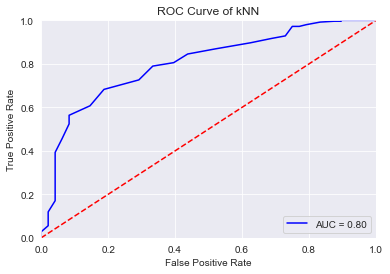

In [141]:
knn.Plot_roc()

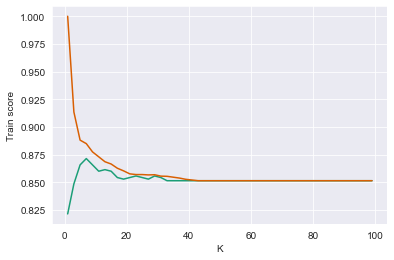

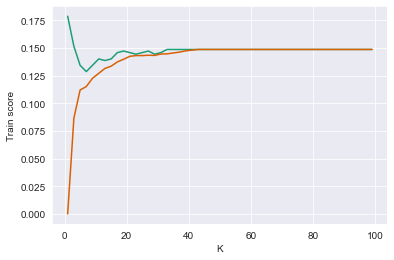

In [143]:
knn.Plot_CV_scrs()

In [138]:
 omodel = knn.KNN_KCV()

100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


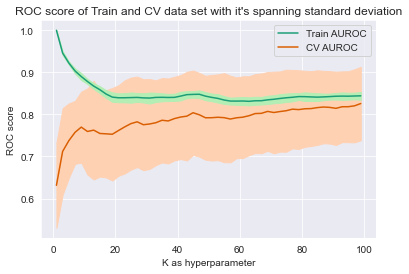

In [144]:
knn.Plot_CV_roc_score()

In [16]:
scores,auc,ok = knn.KNN_KCV(5)

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


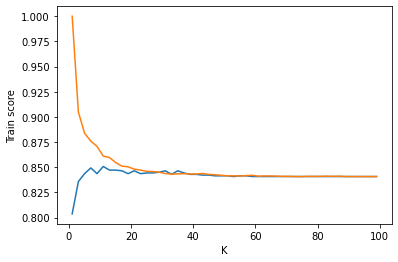

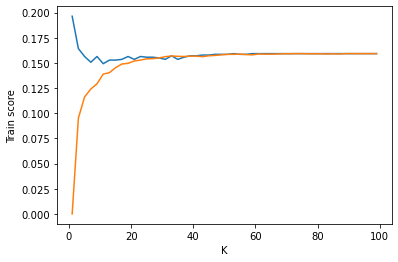

In [17]:
knn.Plot_scrs()

In [18]:
scores,auc,ok = knn.KNN_KCV(20)

100%|██████████| 50/50 [03:55<00:00,  4.72s/it]


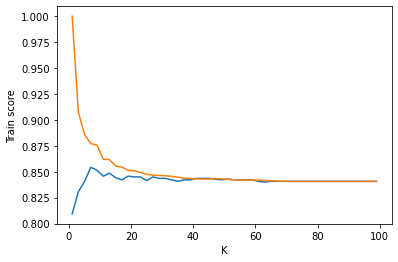

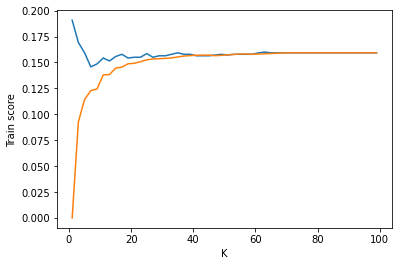

In [20]:
knn.Plot_scrs()

In [247]:
n_list = list(range(1,100,3))
n_list;

In [248]:
x1,x2,y1,y2 = train_test_split(df_upsampled.iloc[:,:50],df_upsampled.iloc[:,50],test_size=0.3,random_state=0)
clf = GridSearchCV(estimator=KNeighborsClassifier(),param_grid={'n_neighbors':n_list},cv=10)
clf.fit(x1,y1)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 4, 7, 10, 13, 16, 19, 22, 25, 28,
                                         31, 34, 37, 40, 43, 46, 49, 52, 55, 58,
                                         61, 64, 67, 70, 73, 76, 79, 82, 85, 88, ...]})

In [249]:
clf.best_estimator_

KNeighborsClassifier(n_neighbors=1)

In [255]:
clf.cv_results_;

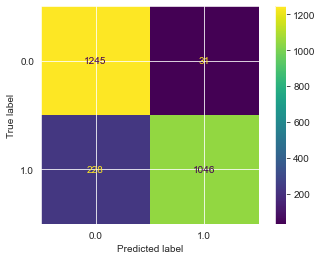

In [250]:
plot_confusion_matrix(clf.best_estimator_,x2,y2)

In [160]:
compute_class_weight(class_weight = 'balanced',classes=[0,1],y=Scr[11000:12000])

array([3.28947368, 0.58962264])

In [34]:
for i in tqdm([1,10**1,10**2,10**3]):
    cvscr = cross_val_score(KNeighborsClassifier(i),avg_w2v[10000:20000],Scr[10000:20000],cv=5)
    print(cvscr.mean())

100%|██████████| 4/4 [00:37<00:00,  9.26s/it]0.8428000000000001



In [35]:
k_lst = range(1,1000,100)
for i in tqdm(k_lst):
    cvscr = cross_val_score(KNeighborsClassifier(i),avg_w2v[10000:20000],Scr[10000:20000],cv=5)
    print(cvscr.mean())

100%|██████████| 10/10 [02:05<00:00, 12.50s/it]0.8428000000000001



In [36]:
for i in tqdm([1,10**1,10**2,10**3]):
    cvscr = cross_val_score(KNeighborsClassifier(i),affr_bow_500[10000:15000],Scr[10000:15000],cv=5)
    print(cvscr.mean())

100%|██████████| 4/4 [03:56<00:00, 59.13s/it]0.8497999999999999



In [41]:
k_lst = range(1,400,50)
for i in tqdm(k_lst):
    cvscr = cross_val_score(KNeighborsClassifier(i),avg_w2v[10000:13000],Scr[10000:13000],cv=5)
    print(cvscr.mean())

100%|██████████| 8/8 [00:26<00:00,  3.31s/it]0.8400000000000001



In [42]:
for i in tqdm([1,10**1,10**2,10**3]):
    cvscr = cross_val_score(KNeighborsClassifier(i),affr_ngram_tfidf_500[10000:20000],Scr[10000:20000],cv=5)
    print(cvscr.mean())

100%|██████████| 4/4 [16:33<00:00, 248.47s/it]0.8428000000000001



In [43]:
k_lst = range(1,400,50)
for i in tqdm(k_lst):
    cvscr = cross_val_score(KNeighborsClassifier(i),affr_ngram_tfidf_500[10000:13000],Scr[10000:13000],cv=5)
    print(cvscr.mean())

100%|██████████| 8/8 [03:01<00:00, 22.67s/it]0.8400000000000001

